In [2]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from joblib import dump, load

In [3]:
# Dataset
(X_train, X_test), (X_test, Y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 784)/255
X_test = X_test.reshape(-1, 784)/255

# Apply a threshold to binarize the image.
X_train = np.where(X_train > 0.2, 1, 0)
X_test = np.where(X_test > 0.2, 1, 0)

# Split into training and validation sets
X_train, X_val = train_test_split(X_train, test_size=1/5,random_state=42)

11501568/11490434 [==============================] - 1s 0us/step


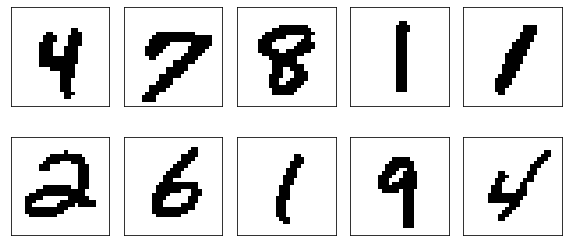

In [6]:
plt.figure(figsize=(8,4))

for i in range(10):
  plt.subplot(2,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(X_train[10+i].reshape(28,28), cmap='Greys')
plt.tight_layout()

In [21]:
rbm = BernoulliRBM(random_state=0, n_components=100,
                    verbose=True, batch_size=20, n_iter=100, learning_rate=0.01)

rbm.fit(X_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -139.27, time = 2.79s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -119.16, time = 3.42s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -109.16, time = 4.41s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -102.69, time = 3.73s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -99.14, time = 3.60s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -96.40, time = 3.66s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -93.37, time = 3.70s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -91.71, time = 3.79s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -90.85, time = 3.83s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -88.74, time = 4.12s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -87.61, time = 4.77s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -87.75, time = 5.58s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -85.93, time = 5.29s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -85.74, time = 4.93s
[BernoulliRBM] Iteration 

BernoulliRBM(batch_size=20, learning_rate=0.01, n_components=100, n_iter=100,
             random_state=0, verbose=True)

In [22]:
print("Training set Pseudo-Likelihood =", rbm.score_samples(X_train).mean())
print("Validation set Pseudo-Likelihood =", rbm.score_samples(X_val).mean())

Training set Pseudo-Likelihood = -72.62279377820806
Validation set Pseudo-Likelihood = -75.86983167432844


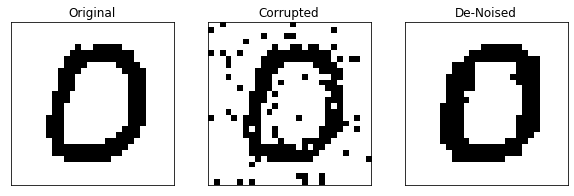

In [26]:
# Pick a random image from the test set
im_ind = 10
X_pick = X_test[im_ind]

# Choose 50 random pixels to flip
corr_pixels = 60
pick = np.random.choice(28 * 28, corr_pixels)
x_noisy = np.copy(X_pick)
x_noisy[pick] = ((X_pick[pick] + 1) % 2)


# Perform the denoising
k_iter = 12  # Number of Gibbs Sampling Iterations
alpha = 0.9  # Decay factor for the averaging

# Gibb sampling steps
b = rbm.gibbs(x_noisy)
x_final = np.zeros(784) + np.copy(b)
for i in range(k_iter):
    b = rbm.gibbs(b)
    x_final += (alpha**(i+1))*b.astype(float) # Averaging the images

# Applying a threshold to binarize the image
x_final = np.where(x_final > 0.5*np.max(x_final), 1, 0)

# Plotting the images
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(X_pick.reshape(28, 28), cmap='Greys')
ax[0].set_title('Original')
ax[1].imshow(x_noisy.reshape(28, 28), cmap='Greys')
ax[1].set_title('Corrupted')
ax[2].imshow(x_final.reshape(28, 28), cmap='Greys')
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[2].set_title('De-Noised')
plt.show()

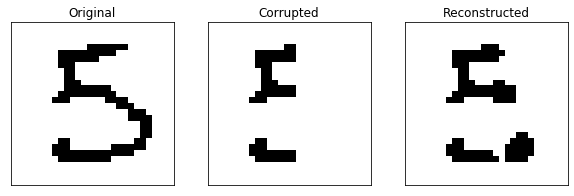

In [27]:
# Pick another random image and set some parts of the image to zero.
im_ind = 15
X_missing = X_test[im_ind].copy().reshape(28,28)
X_missing[:,15:] = 0

# Image Reconstruction
k_iter = 100 # Number of Gibbs iterations
alpha = 0.9  # Decay factor

X_recon = np.zeros((28,13)) # Array to store the reconstruction

b = X_missing.copy().reshape(-1)
for i in range(k_iter):
  b = rbm.gibbs(b)
  X_recon += alpha**(i) * b.reshape(28,28)[:,15:]
  b.reshape(28,28)[:,:15] = X_missing[:,:15]

# Apply a threshold and complete the image
X_recon = np.where(X_recon > 0.5*np.max(X_recon), 1, 0)
X_complete = X_missing.copy()
X_complete[:,15:] = X_recon

# Plot the figures
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(X_test[im_ind].reshape(28, 28), cmap='Greys')
ax[0].set_title('Original')
ax[1].imshow(X_missing, cmap='Greys')
ax[1].set_title('Corrupted')
ax[2].imshow(X_complete.reshape(28,28), cmap='Greys')
ax[2].set_title('Reconstructed')
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()